# MRL Eye Dataset Classification

This notebook implements a classification task using the MRL Eye Dataset, which consists of images of human eyes. The aim is to classify images into 'open_eye' and 'closed_eye' categories. The dataset includes images captured in varying lighting conditions and by different devices.

### Dataset Overview:
The MRL Eye Dataset is a large-scale collection of infrared images prepared for classification tasks. It is divided into categories like open and closed eyes to facilitate training and testing.

Full dataset available here: [MRL Eye Dataset](http://mrl.cs.vsb.cz/eyedataset)


## Imports

Below are the libraries and modules used in this project, including libraries for image processing (`PIL`), deep learning (`torch` and `torchvision`), and utilities like `tqdm` for progress bars and `mlflow` for tracking experiments.


In [1]:
import os
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from timeit import default_timer as timer
from torchinfo import summary
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, random_split
import torchvision
from torchvision import transforms, datasets
import mlflow

### Device Setup

Determines the appropriate device for PyTorch operations. The device is chosen based on the availability of CUDA (NVIDIA GPUs) or MPS (Apple Silicon GPUs).
If neither is available, it defaults to the CPU.



In [2]:
device = (
    "cuda" if torch.cuda.is_available()
    
    else "mps" if torch.backends.mps.is_available() 
    
    else "cpu"
)

device

'mps'

## Dataset Exploration

This part of the notebook explores the structure of the dataset, counting the number of folders and files in the respective directories for 'open_eye' and 'closed_eye'.


In [3]:
dataset_path = "MRL Eye Dataset"


def print_directory_structure(dir_path):
    for dirpaths, dirnames, filenames in os.walk(dir_path):
        print(f"there {len(dirnames)} Folders, and {len(filenames)} Files in '{dirpaths}'.")


print_directory_structure(dataset_path)

there 2 Folders, and 1 Files in 'MRL Eye Dataset'.
there 0 Folders, and 24000 Files in 'MRL Eye Dataset/open_eye'.
there 0 Folders, and 24000 Files in 'MRL Eye Dataset/closed_eye'.


## Data Transformation

The images are resized to 128x128 pixels and converted to grayscale. The transformation is applied using the `torchvision.transforms` module, and the dataset is loaded into a PyTorch `ImageFolder` dataset for easy handling.


In [4]:
image_transforms = transforms.Compose(
    [transforms.Resize(size=(128, 128)), transforms.Grayscale(), transforms.ToTensor()]
)
dataset = datasets.ImageFolder(root=dataset_path, transform=image_transforms)

class_idx = dataset.class_to_idx
print(f"Index of classes are: {class_idx}")

class_names = list(class_idx)
print(f"\nClass Names are: {class_names}")

Index of classes are: {'closed_eye': 0, 'open_eye': 1}

Class Names are: ['closed_eye', 'open_eye']


## Data Splitting

In this section, we split the dataset into training and validation sets. The dataset is first loaded using the `ImageFolder` class, and then split into training and validation subsets using `random_split`. This allows us to evaluate model performance on unseen data during training.


In [5]:
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size

train_dat, test_dat = random_split(dataset, [train_size, test_size])

len(train_dat), len(test_dat)

(38400, 9600)

## Dataloader Setup

Here we use the `DataLoader` class to prepare batches of images for training and validation. The `DataLoader` ensures efficient loading of data, especially when working with large datasets, by loading batches in parallel using multiple workers.


In [6]:
BATCH_SIZE = 32
NUM_WORK = os.cpu_count()

train_dataloader = DataLoader(
    dataset=train_dat, batch_size=BATCH_SIZE, num_workers=NUM_WORK, shuffle=True
)

test_dataloader = DataLoader(
    dataset=test_dat, batch_size=BATCH_SIZE, num_workers=NUM_WORK, shuffle=False
)

## Visualizes
generate a grid of 3x3 random images from the training dataset. This cell creates a 3x3 grid of images using matplotlib, where each image is randomly selected from the training dataset. Each subplot displays an image along with its corresponding class name as the title.


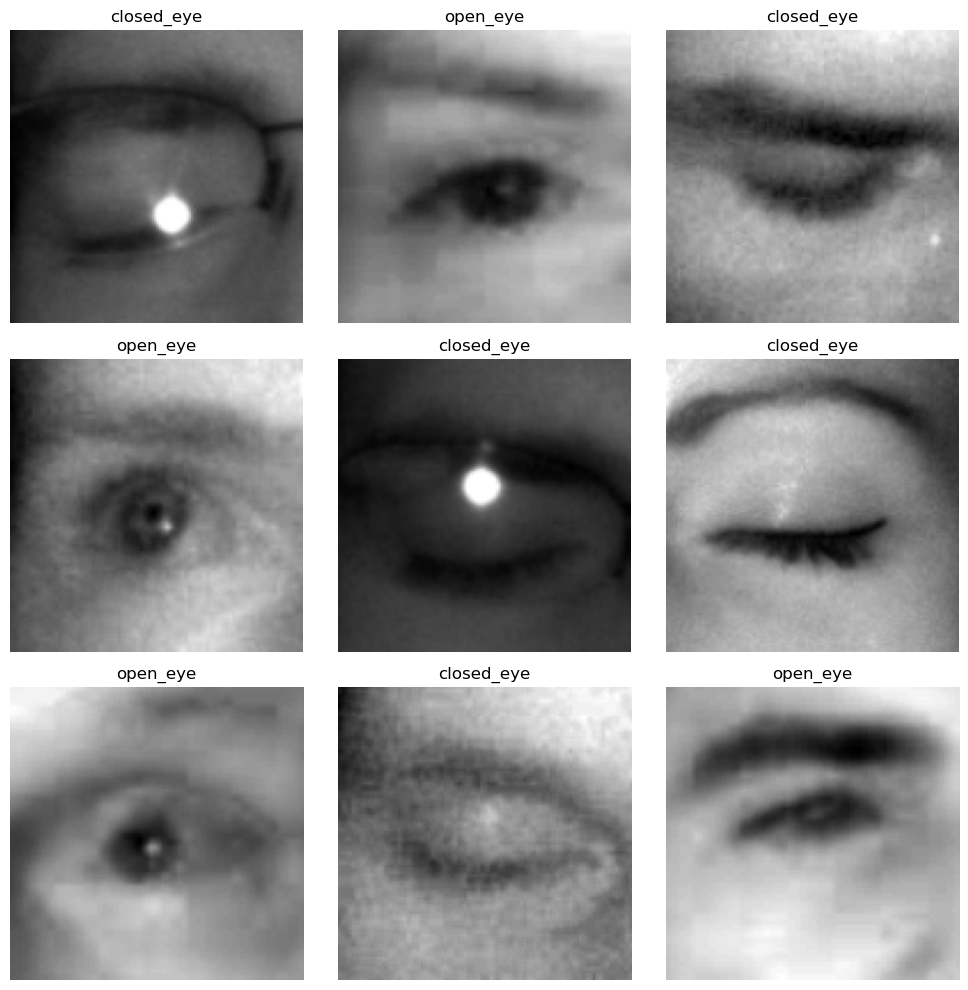

In [7]:
fig = plt.figure(figsize=(10, 10))

row, col = 3, 3

for i in range(9):
    ax = fig.add_subplot(row, col, i + 1)
    random_idx = torch.randint(low=0, high=len(train_dat), size=[1]).item()
    img, label = train_dat[random_idx]

    ax.imshow(img.squeeze(), cmap="gray")
    ax.set_title(class_names[label])
    ax.axis("off")  

plt.tight_layout()  
plt.show()

In [8]:
model_name = "efficientnet_b0"
model = torchvision.models.efficientnet_b0(weights="DEFAULT")

model.features[0][0]=nn.Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)

model.classifier[1]=nn.Linear(in_features=1280, out_features=2, bias=True)
model.to(device)

EPOCHS = 1
LR = 1e-3
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=LR)

In [ ]:
from utils.train_with_mlflow import training
mlflow.autolog()
mlflow.set_experiment("openOrCloseEye")



with mlflow.start_run() as run:
    params = {
        "model name": model_name,
        "epochs": EPOCHS,
        "learning_rate": LR,
        "batch_size": BATCH_SIZE,
        "loss_function": loss_fn.__class__.__name__,
        "optimizer": "Adam",
    }
    # Log training parameters.
    mlflow.log_params(params)

    # Log model summary.
    current_dir = os.getcwd()  # Get the current working directory
    summary_file = os.path.join(current_dir, "model_summary.txt")

# Write the model summary to the file
    with open(summary_file, "w") as f:
        f.write(str(summary(model)))

    start_time = timer()

    model0_res = training(
        model=model,
        train_dataloader=train_dataloader,
        test_dataloader=test_dataloader,
        optimizer=optimizer,
        loss_fn=loss_fn,
        epochs=EPOCHS,
        device=device,
    )

    end_time = timer()
    print(f"Total training time: {end_time-start_time:.3f} seconds")


In [13]:
!mlflow ui

### Model Performance Evaluation

The following plots show the training and test accuracy for different models evaluated in this experiment:

#### Train Accuracy
![Train Accuracy](train_accuracy_plot.png)

#### Test Accuracy
![Test Accuracy](test_accuracy_plot.png)


## Experiment Summary

In this experiment, I evaluated the performance of various deep learning models, including ConvNext, VGG11, DenseNet121, ResNet50, ResNet18, and EfficientNet variations (B0, B1, B2).

### Model Architectures:
1. **ConvNext_small**: A state-of-the-art vision model inspired by CNN architectures.
2. **VGG11**: A classic convolutional neural network model.
3. **DenseNet121**: A densely connected convolutional network.
4. **ResNet50**: A deeper residual network with 50 layers.
5. **ResNet18**: A smaller version of ResNet for faster computation.
6. **EfficientNet**: A family of models that optimize both efficiency and accuracy.

### Results:
Based on the results, EfficientNet (B1 and B0) emerged as the top performers in both training and test accuracy, proving to be highly efficient and accurate. DenseNet121 and ResNet18 also provided competitive performance, while ConvNext_small and ResNet50 underperformed. Further hyperparameter tuning and investigation into the ResNet50 model might be necessary to improve its performance.
